In [ ]:
from google.colab import drive
drive.mount('/content/drive',timeout_ms=600000)

Mounted at /content/drive


In [ ]:
import numpy as np
import concurrent.futures
import glob
import csv
import pandas as pd
import os
import threading
import random

In [ ]:
# Dosya yollarını listele
npy_files_1 = glob.glob('/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb*/*1.npy')
npy_files_0 = glob.glob('/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb*/*0.npy')
npy_files_2 = glob.glob('/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb*/*2.npy')

npy_files = npy_files_1 + npy_files_0
random.shuffle(npy_files)

npy_files = npy_files[:9000]

npy_files = npy_files + npy_files_2
random.shuffle(npy_files)
# Çıktıyı yazdır
print(npy_files)

# Dizi şekli ve veri türü
shape = (2530, 155, 3)
dtype = 'uint8'
length = len(npy_files)

# Etiket ve dizi listelerini oluştur
label_list = [3.0] * length
arrays_list = np.zeros((length, *shape), dtype=dtype)

['/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb13_59/chb13_59_3393_2.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb08_21/chb08_21_2189_2.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb08_02/chb08_02_2733_2.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb24_17/chb24_17_3154_1.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb15_46/chb15_46_2212_1.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb10_31/chb10_31_6975_0.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb24_06/chb24_06_1641_0.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb11_99/chb11_99_1674_2.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb17_03/chb17_03_2019_1.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb08_21/chb08_21_2165_2.npy', '/content/drive/MyDrive/Dataset_Models/dataset/trail/npys15/chb01_16/chb01_16_72_1.npy', 

In [ ]:
print(len(npy_files))
print(len(npy_files_0))
print(len(npy_files_1))
print(len(label_list))
print(len(arrays_list))

15885
9468
9449
15885
15885


In [ ]:
# Kilit oluştur
lock = threading.Lock()

def process_file(index, file_path):
    npa = np.load(file_path)
    if npa is not None:
        with lock:
            print(index, file_path)
            arrays_list[index] = npa

def process_files(file_paths):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_file, i, file_path) for i, file_path in enumerate(file_paths)]
        concurrent.futures.wait(futures)

process_files(npy_files)

print(arrays_list)



In [ ]:
for index, array in enumerate(arrays_list):
    label = array[0][0][0]
    if(label>2):
        print("label hatası")
    label_list[index] = label
    print(f"Index: {index}, Array: {array}")

In [ ]:
from collections import Counter

frequency = Counter(label_list)
print(frequency)

Counter({2: 6885, 1: 4540, 0: 4460})


In [ ]:
y_train = np.array(label_list)

print(y_train.shape)
print(y_train)
del label_list

(15885,)
[2 2 2 ... 1 2 2]


In [ ]:
for i in range(len(y_train)):
    if y_train[i] == 1:
       y_train[i] = 0

In [ ]:
for i in range(len(y_train)):
    if y_train[i] == 2:
        y_train[i] = 1

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
print(y_train)
print(y_train.shape)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
(15885, 2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50,ResNet101,InceptionV3,ResNet152V2,DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import Adam

optimizers = Adam(learning_rate=0.001)

base_resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(2530, 155, 3))
base_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(2530, 155, 3))
base_inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(2530, 155, 3))
base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(2530, 155, 3))
#base_resnet2 = ResNet50(weights='imagenet', include_top=False , input_shape=(2530, 155, 3))
#base_resnet152 = ResNet152V2(weights='imagenet', include_top=False, input_shape=(2530, 155, 3))

model = Sequential()
model.add(base_efficientnet)
model.add(Conv2D(128, (1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

# Modeli derleme
model.compile(optimizer= optimizers, loss='binary_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
#from sklearn.utils import shuffle
X_train = arrays_list
#X_train, y_train = shuffle(arrays_list, y_train, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12708, 2530, 155, 3)
X_val shape: (1588, 2530, 155, 3)
X_test shape: (1589, 2530, 155, 3)
y_train shape: (12708, 2)
y_val shape: (1588, 2)
y_test shape: (1589, 2)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=40,callbacks=[early_stopping])

Epoch 1/40
795/795 [==============================] - 257s 267ms/step - loss: 0.4810 - accuracy: 0.7875 - val_loss: 0.5183 - val_accuracy: 0.8413
Epoch 2/40
795/795 [==============================] - 207s 261ms/step - loss: 0.3134 - accuracy: 0.8791 - val_loss: 0.2712 - val_accuracy: 0.8936
Epoch 3/40
795/795 [==============================] - 207s 261ms/step - loss: 0.2331 - accuracy: 0.9090 - val_loss: 0.4125 - val_accuracy: 0.8331
Epoch 4/40
795/795 [==============================] - 207s 261ms/step - loss: 0.1949 - accuracy: 0.9245 - val_loss: 0.1592 - val_accuracy: 0.9389
Epoch 5/40
795/795 [==============================] - 207s 261ms/step - loss: 0.1745 - accuracy: 0.9348 - val_loss: 0.1470 - val_accuracy: 0.9503
Epoch 6/40
795/795 [==============================] - 207s 261ms/step - loss: 0.1580 - accuracy: 0.9434 - val_loss: 0.1988 - val_accuracy: 0.9383
Epoch 7/40
795/795 [==============================] - 207s 261ms/step - loss: 0.1400 - accuracy: 0.9477 - val_loss: 0.2014 -

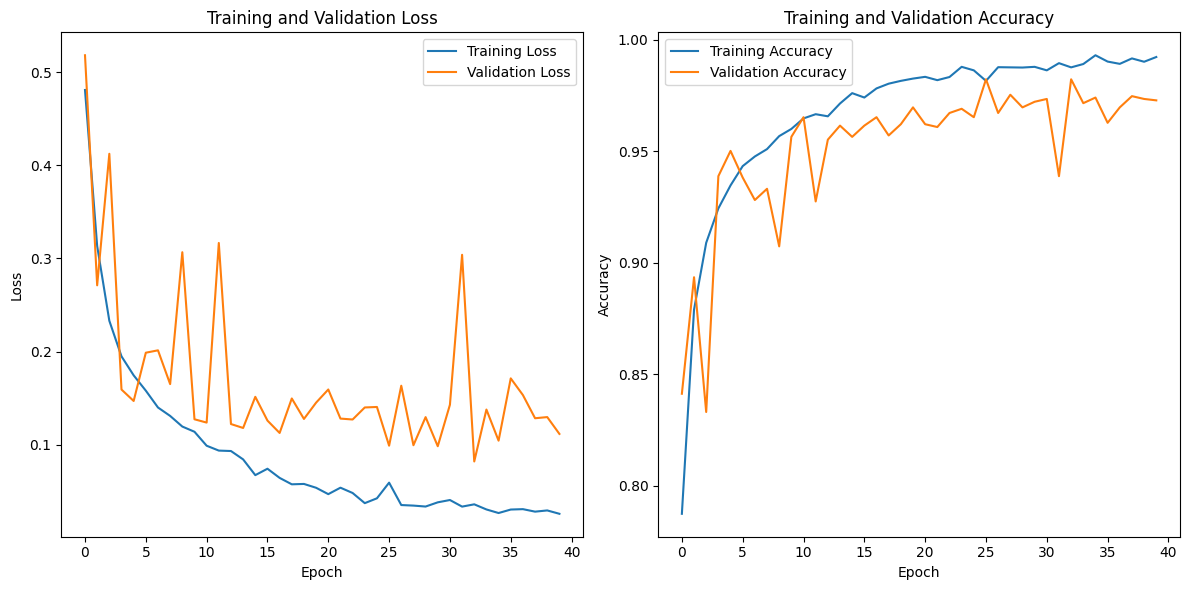

In [ ]:
import matplotlib.pyplot as plt

# loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# acc values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# loss graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# acc graph
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix

model.evaluate(x = X_test, y = y_test)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

50/50 [==============================] - 6s 98ms/step
[[886  34]
 [ 14 655]]


In [ ]:
import seaborn as sns

#cm heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Dataset_Models/dataset/trail/binary_model_efficient_var_yok.h5')
model.save('/content/drive/MyDrive/Dataset_Models/dataset/trail/binary_model_efficient_var_yok.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# import gc
# gc.collect()

# import tensorflow as tf
# tf.keras.backend.clear_session()